**HW 2/1**: <br>
Smart up our plotter to be able to customize the hard-coded layout setup inside the function. Add more custom feature that you would like to use.


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from typing import Dict, List, Union
from scipy.stats import norm


In [8]:
# Added customizable elements for the plotter, including colors, figsize, linewidth, grid etc. 
def my_plotter(
    x: List[float], 
    y: Union[List[float], List[List[float]]], 
    layout: Dict = {}, 
    names: List[str] = None, 
    colors: List[str] = None, 
    linestyles: List[str] = None, 
    markers: List[str] = None
):
    """Enhanced plotter with more customization options."""
    
    y = [y] if all(isinstance(item, float) for item in y) else y

    plt.figure(figsize=layout.get("figsize", (8, 4)))   
    lines = []
    
    if names is not None: 
        show_legend = True
    if names and len(names) != len(y):
        raise ValueError("Length of names does not match number of y lists.")
    
    # Default plot style settings, adjustable linewidth
    default_plot_kwargs = {
        'linestyle': 'solid',
        'linewidth': layout.get("linewidth", 2) 
    }
    
    # We iterate through the list of series, define the label, color and linestyle for each series
    for i, y_item in enumerate(y):
        plot_kwargs = default_plot_kwargs.copy()
        if show_legend:
            plot_kwargs['label'] = names[i]
        if colors:
            plot_kwargs['color'] = colors[i % len(colors)]
        if linestyles:
            plot_kwargs['linestyle'] = linestyles[i % len(linestyles)]
        if markers:
            plot_kwargs['marker'] = markers[i % len(markers)]
            
        _line = plt.plot(x, y_item, **plot_kwargs)
        lines.append(_line)

    if show_legend:
        plt.legend(fontsize=16)
    if 'title' in layout:
        plt.title(layout['title'], fontsize=20)
        rcParams['axes.titlepad'] = 30
 
    # Customize axis labels 
    if "x_label" in layout:
        plt.xlabel(layout["x_label"], fontsize=layout.get("label_fontsize", 16))
    if "y_label" in layout:
        plt.ylabel(layout["y_label"], fontsize=layout.get("label_fontsize", 16))

    # Customize axis limits
    if "x_lim" in layout:
        plt.xlim(layout["x_lim"])
    if "y_lim" in layout:
        plt.ylim(layout["y_lim"])

    # Grid customization
    if layout.get("grid", False):
        plt.grid(True, linestyle=layout.get("grid_style", "--"), alpha=layout.get("grid_alpha", 0.6))

    # Adjust tick size
    if "tick_fontsize" in layout:
        plt.xticks(fontsize=layout["tick_fontsize"])
        plt.yticks(fontsize=layout["tick_fontsize"])

    ax = plt.gca() # gca: get current axes
    ax.axhline(linestyle='--', color='black', linewidth=1)
    plt.show()


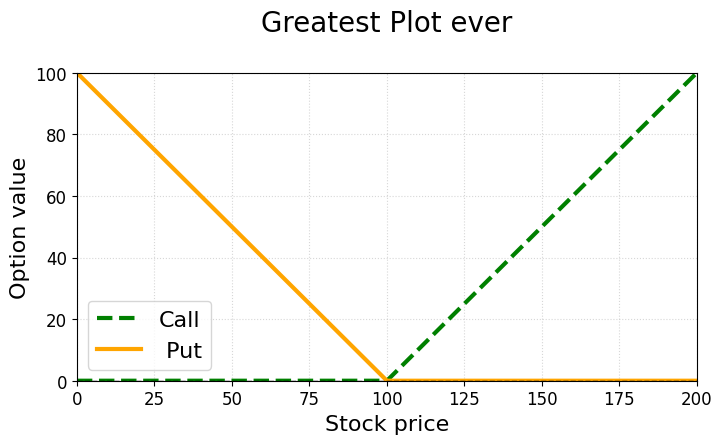

In [32]:
K = 100
x = np.arange(0,200,0.5)
y1 = [max(0,i - K) for i in x]
y2 = [max(K - i,0) for i in x]  


layout = {
    "title": "Greatest Plot ever",
    "x_label": "Stock price",
    "y_label": "Option value",
    "x_lim": (0, 200),
    "y_lim": (0, 100),
    "grid": True,
    "grid_style": "dotted",
    "grid_alpha": 0.5,
    "tick_fontsize": 12,
    "legend_loc": "upper left",
    "legend_fontsize": 14,
    "linewidth": 3
}

my_plotter(x, [y1, y2], layout, names=["Call", " Put"], colors=["green", "orange"], linestyles=["dashed", "solid"])


**HW 2/2**: <br>
Upgrade the BSM call option pricer to be able to return the greeks as well, not just the price.



In [ ]:
"""The pricing function of European call option"""
def black_scholes_eur_call(
        r: float, 
        T: float, 
        S0: float, 
        sigma: float, 
        K: Union[float, List[float]],
        include_greeks: bool = False) -> Dict:

    """
    Black-Scholes pricer of European call option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    include_greeks: also returns greek letters delta, gamma, vega, theta, rho
    """
    # check conditions
    assert sigma > 0

    K = np.array([K]) if isinstance(K, float) else np.array(K)

    d1 = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2 = d1 - sigma * T**0.5

    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    price = N_d1 * S0 - K * np.exp(-r * T) * N_d2

    # Greeks
    if include_greeks:
        delta = N_d1
        gamma = norm.pdf(d1) / (S0 * sigma * np.sqrt(T))
        vega = S0 * norm.pdf(d1) * np.sqrt(T)
        theta = (- (S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N_d2)
        rho = K * T * np.exp(-r * T) * N_d2
        return {"price": price,
                "delta": delta,
                "gamma": gamma,
                "vega": vega,
                "theta": theta,
                "rho": rho,}
    else:
        return {"price": price}
    

In [ ]:
r = 0.05     
T = 1.0     
S0 = 100     
sigma = 0.2   
K = [90, 100, 110]

result = black_scholes_eur_call(r, T, S0, sigma, K, include_greeks=True)
for key, value in result.items():
    print(f"{key}: {value}")


price: [16.69944841 10.45058357  6.04008813]
delta: [0.80970306 0.63683065 0.44964793]
gamma: [0.01358129 0.01876202 0.01978802]
vega: [27.16257949 37.52403469 39.57604804]
theta: [-5.92980083 -6.41402755 -5.90384005]
rho: [64.27085767 53.23248155 38.92470493]


**HW 2/3**: <br>
Implement the BSM pricer for European put option.

In [53]:

def black_scholes_eur_put(
        r: float, 
        T: float, 
        S0: float, 
        sigma: float, 
        K: Union[float, List[float]]) -> Dict:
    
    """
    Black-Scholes pricer of European put option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    # check conditions
    assert sigma > 0

    # Convert K to a NumPy array (handles multiple strike prices)
    K = np.array([K]) if isinstance(K, float) else np.array(K)

    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    N_d1 = norm.cdf(-d1)
    N_d2 = norm.cdf(-d2)

    return  {"price" :K * np.exp(-r * T) * N_d2 - S0 * N_d1}

In [54]:
r = 0.05     
T = 1.0     
S0 = 100     
sigma = 0.2   
K = [90, 100, 110]

result = black_scholes_eur_put(r, T, S0, sigma, K)
for key, value in result.items():
    print(f"{key}: {value}")

price: [ 2.31009661  5.57352602 10.67532482]


**HW 2/4**: <br>
With the call and put pricer, check if Put-Call parity holds in practice.

In [61]:
def check_put_call_parity(
    r: float, 
    T: float, 
    S0: float, 
    sigma: float, 
    K: Union[float, List[float]], 
    tolerance: float = 1e-3):

    """
    Verifies Put-Call Parity: C - P = S0 - K * exp(-rT)

    Parameters:
    - r: Risk-free interest rate
    - T: Time to maturity (in years)
    - S0: Initial stock price
    - sigma: Volatility of the underlying asset
    - K: Strike price (or a list of strike prices)
    - tolerance: Allowed numerical error in the check

    Returns:
    - True if Put-Call Parity holds, False otherwise
    """
    assert sigma > 0
    K = np.array(K) if isinstance(K, list) else np.array([K])
    
    call_data = black_scholes_eur_call(r, T, S0, sigma, K)
    put_data = black_scholes_eur_put(r, T, S0, sigma, K)

    call_price = call_data["price"]
    put_price = put_data["price"]

    

    lhs = call_price - put_price
    rhs = S0 - K * np.exp(-r * T)

    parity_holds = np.allclose(lhs, rhs, atol=tolerance)

    return parity_holds, lhs, rhs

In [60]:
r = 0.05      
T = 1.0      
S0 = 100     
sigma = 0.2   
K = [90, 100, 110] 

parity_holds, lhs, rhs = check_put_call_parity(r, T, S0, sigma, K)

print(f"Put-Call Parity Holds: {parity_holds}")
print(f"c - p: {lhs}")
print(f"S_0 - K*exp(-rT)): {rhs}")

Put-Call Parity Holds: True
c - p: [14.38935179  4.87705755 -4.6352367 ]
S_0 - K*exp(-rT)): [14.38935179  4.87705755 -4.6352367 ]
